# Run LAMMPS with atomman

Tools for setting up and running LAMMPS calculations are available in the atomman.lammps submodule

In [22]:
from pathlib import Path

import matplotlib.pyplot as plt
import random
import numpy as np

import atomman as am
import atomman.unitconvert as uc
import atomman.lammps as lmp

## 1. Specify *your* LAMMPS and mpi_commands

In [3]:
lammps_command = 'lmp_serial'
mpi_command = None
#mpi_command = 'mpiexec -localonly 6'

## 2. Load a potential, unit cell, and build a system

In [4]:
potential = am.load_lammps_potential('2004--Zhou-X-W--Au--LAMMPS--ipr1', getfiles=True)

ucell = am.load('crystal', potential=potential, family='A1--Cu--fcc', symbols='Au')
print(ucell)

avect =  [ 4.080,  0.000,  0.000]
bvect =  [ 0.000,  4.080,  0.000]
cvect =  [ 0.000,  0.000,  4.080]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Au',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.040 |   2.040
      2 |       1 |   2.040 |   0.000 |   2.040
      3 |       1 |   2.040 |   2.040 |   0.000


Now, we're going to make a 6x6x6 supercell and randomly delete 2 atoms just for fun.

In [5]:
system = ucell.supersize(6, 6, 6)

In [9]:
# Random shuffle atom ids
allids = [i for i in range(system.natoms)]
random.shuffle(allids)

# Slice system with atoms_ix using all ids except for the first 2
system = system.atoms_ix[allids[2:]]
print(system.natoms)

3995


## 3. Define a template LAMMPS script

This script is designed to evaluate mean squared displacements.  All values in "\<\>" are variables that are to be filled in from Python.

In [10]:
template = """
# LAMMPS input script for dynamic msd computation

<atomman_system_pair_info>

# Assign simulation parameter values
variable temperature equal <temperature>
variable randomseed equal <randomseed>
variable thermosteps equal <thermosteps>
variable timestep equal <timestep>
variable dumpsteps equal <dumpsteps>
variable runsteps equal <runsteps>
variable twotemp equal 2*${temperature}
variable damptemp equal 100*${timestep}

# Specify property computes
compute peatom all pe/atom
compute msd all msd com yes

# Define thermo data
thermo ${thermosteps}
thermo_style custom step temp pe ke etotal pxx pyy pzz c_msd[1] c_msd[2] c_msd[3] c_msd[4]
thermo_modify format float %.13e

# Specify timestep
timestep ${timestep}

# Define dump file contents and frequency
dump dumpit all custom <dumpsteps> *.dump id type x y z c_peatom
dump_modify dumpit format float %.13e

# Create velocities and equilibrate system using nvt
velocity all create ${twotemp} ${randomseed}
fix nvt all nvt temp ${temperature} ${temperature} ${damptemp}
run ${runsteps}

"""

## 4. Build LAMMPS script by filling in the template

Save the system to a data file

In [11]:
data_file = 'init.dat'
system_pair_info = system.dump('atom_data', f=data_file, potential=potential)

Build dict of terms to fill in

In [13]:
lammps_variables = {}
lammps_variables['atomman_system_pair_info'] = system_pair_info
lammps_variables['temperature'] = 1000
lammps_variables['randomseed'] = lmp.newseed()              # generates a random LAMMPS-compatible random seed
lammps_variables['thermosteps'] = 100
lammps_variables['timestep'] = lmp.style.timestep('metal')  # selects the default timestep to use for a unit style
lammps_variables['dumpsteps'] = 10000
lammps_variables['runsteps'] = 100000

In [14]:
script = am.tools.filltemplate(template, lammps_variables, '<', '>')
print(script)


# LAMMPS input script for dynamic msd computation

units metal
atom_style atomic

boundary p p p
read_data init.dat

print "Parameter file(s) can be downloaded at:"
print "https://www.ctcms.nist.gov/potentials/Download/2004--Zhou-X-W-Johnson-R-A-Wadley-H-N-G--Au/2/Au.set"

pair_style eam/alloy 
pair_coeff * * 2004--Zhou-X-W--Au--LAMMPS--ipr1\Au.set Au

mass 1 196.97



# Assign simulation parameter values
variable temperature equal 1000
variable randomseed equal 716041761
variable thermosteps equal 100
variable timestep equal 0.001
variable dumpsteps equal 10000
variable runsteps equal 100000
variable twotemp equal 2*${temperature}
variable damptemp equal 100*${timestep}

# Specify property computes
compute peatom all pe/atom
compute msd all msd com yes

# Define thermo data
thermo ${thermosteps}
thermo_style custom step temp pe ke etotal pxx pyy pzz c_msd[1] c_msd[2] c_msd[3] c_msd[4]
thermo_modify format float %.13e

# Specify timestep
timestep ${timestep}

# Define dump file conten

## 5. Run LAMMPS and explore results

In [15]:
log = lmp.run(lammps_command, script=script, mpi_command=mpi_command)

In [17]:
thermo = log.simulations[0].thermo
thermo

,Step,Temp,PotEng,KinEng,TotEng,Pxx,Pyy,Pzz,c_msd[1],c_msd[2],c_msd[3],c_msd[4]
0,0,2000.000000,-15694.943169,1032.530038,-14662.413131,15905.714141,15835.098250,15714.052607,2.839899e-27,8.077936e-28,1.212953e-26,1.577722e-26
1,100,636.166363,-15044.706833,328.430440,-14716.276393,82299.336143,83927.783907,82512.809019,3.429656e-02,3.296991e-02,3.449804e-02,1.017645e-01
2,200,865.763840,-15102.268588,446.963585,-14655.305003,78854.986403,79333.232738,77975.541074,4.310560e-02,3.977673e-02,4.316342e-02,1.260457e-01
3,300,1067.926345,-15174.147602,551.333015,-14622.814587,71666.058602,71958.638093,70652.757415,4.135062e-02,3.712161e-02,3.985539e-02,1.183276e-01
4,400,1033.485037,-15185.544817,533.552173,-14651.992644,69899.488188,70487.366108,69797.750684,4.057064e-02,3.801067e-02,3.898256e-02,1.175639e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
996,99600,992.495949,-15180.134220,512.390940,-14667.743280,69668.930180,70484.620355,70860.238231,5.783345e-02,4.310484e-02,4.943760e-02,1.503759e-01
997,99700,1010.917488,-15193.124553,521.901337,-14671.223216,69446.261448,68335.902962,69400.260981,5.684298e-02,4.266532e-02,4.914992e-02,1.486582e-01
998,99800,983.384222,-15186.171365,507.686874,-14678.484491,69559.046418,68978.023641,70123.319727,5.615163e-02,4.242825e-02,5.069410e-02,1.492740e-01
999,99900,1001.234954,-15194.741788,516.902583,-14677.839206,69614.948446,68485.943439,68881.502831,5.569187e-02,4.307428e-02,5.018378e-02,1.489499e-01


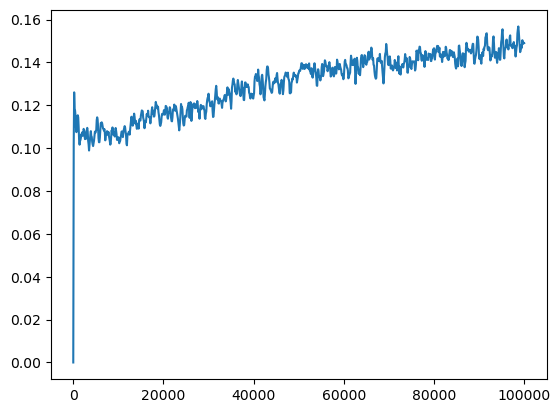

In [18]:
plt.plot(thermo.Step, thermo['c_msd[4]'])

In [20]:
final = am.load('atom_dump', '100000.dump')
print(final.atoms_prop())

['atype', 'pos', 'atom_id', 'c_peatom']


File cleanup

In [23]:
for fname in Path().glob('*.dump'):
    fname.unlink()
Path('log.lammps').unlink()